<a href="https://colab.research.google.com/github/xymeo/fashion-mnist-cnn/blob/main/fashion_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project is to compare the accuracy of recognizing objects from the Fashion MNIST dataset. 

The loss generated per epoch, and training and validation accuracies are discussed.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# The Dataset

We create the transforms for training and validation, create training and validation datasets, and Dataloaders. 

In [15]:
batch_size = 64
transform_training = transforms.Compose([
                                        transforms.RandomAffine(degrees=(20),
                                                                translate=(0.1, 0.1), 
                                                                scale=(0.8, 1.2)),
                                        transforms.RandomHorizontalFlip(),
                                        # transforms.RandomVerticalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5)),
                                        ])
transform_validation = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5), (0.5)),
                                        ])
training_set = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform_training)
validation_set = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform_validation)


In [18]:
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_set, batch_size=batch_size)

### Visualizing the data and associated labels 

In [19]:
labels = dict(zip(np.arange(10),
                  ['T-shirt/top',
                   'Trouser',
                   'Pullover',
                   'Dress',
                   'Coat',
                   'Sandal',
                   'Shirt',
                   'Sneaker',
                   'Bag',
                   'Ankle Boot']))

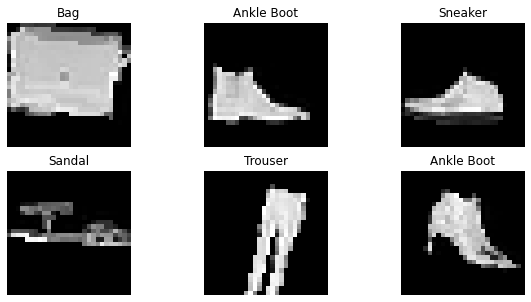

In [20]:
figure = plt.figure(figsize=(10, 5))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_set), size=(1,)).item()
    img, label = training_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [21]:
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

# Creating Models



### Defining the Convolutional Neural Network (CNN)

In [62]:
class CNN(nn.Module):
  def __init__(self):
    
    super().__init__()
    
    self.conv_block = nn.Sequential(
      # 1st Conv Block 
      nn.Conv2d(in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=2),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(2, 2),
      nn.ReLU(),
      nn.Dropout(0.2),

      # 2nd Conv Block 
      nn.Conv2d(in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1,                   
                padding=2),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(2, 2),
      nn.ReLU())
  
    self.activation = F.relu
    self.fc1 = nn.Linear(2048, 1024)
    self.fc2 = nn.Linear(1024, 10)

      
    
  def forward(self,x): 
    x = self.conv_block(x)
    x = torch.flatten(x,1)
    x = self.activation(self.fc1(x))
    x = self.fc2(x)
    return x


cnn = CNN() 
cnn


CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

### Defining Loss Function and Learning Rate

In [76]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training the Model 

In [63]:
def training_loop(model, learning_rate, num_epochs=5):

  training_loss_history, val_loss_history = [], []
  training_acc_history, val_acc_history = [], []

  # defining the Optimizer 
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  if torch.cuda.is_available():
    model = model.cuda() # Enable GPU 
  for epoch in range(num_epochs):
      model.train()
      train_loss = 0.0
      train_correct = 0 # Number of correct predictions in training set
      training_acc = 0.0
      
      for i, data in enumerate(tqdm(train_loader)):
          inputs, labels = data
          if torch.cuda.is_available():  # Enable GPU if available
              inputs, labels = inputs.cuda(), labels.cuda()
              
          optimizer.zero_grad() # Set gradients of all weights to 0 
          outputs = model(inputs) # Get the output 
          loss = loss_function(outputs, labels) # Calculate loss agains labels 
          loss.backward() # Calculate dloss/dx for parameters x 
          optimizer.step() # Parameter update

          _, preds = torch.max(outputs.data, 1)
          train_correct += (preds == labels).sum().item()
          train_loss += loss.item()
        
      training_acc = train_correct * 100 /len(training_set)
      print(f'Epoch {epoch + 1} training accuracy: {training_acc:.2f}% training loss: {train_loss/len(training_set):.5f}')
      training_loss_history.append(train_loss/len(training_set))
      training_acc_history.append(training_acc)

      val_loss = 0.0
      val_correct = 0 # Number of correct predictions in training set
      validation_acc = 0.0
      with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs) # Get output
            loss = loss_function(outputs, labels) 

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
      
      validation_acc = val_correct * 100 /len(validation_set)
      print(f'Epoch {epoch + 1} validation accuracy: {validation_acc:.2f}% validation loss: {val_loss/len(validation_set):.5f}')
      val_loss_history.append(val_loss/len(validation_set))
      val_acc_history.append(validation_acc)

  return training_loss_history, val_loss_history, training_acc_history, val_acc_history

### Training on CNN 

In [67]:
training_loss_history_cnn, val_loss_history_cnn, training_acc_history_cnn, val_acc_history_cnn = training_loop(cnn, learning_rate=0.001, num_epochs=30)

100%|██████████| 938/938 [00:22<00:00, 42.16it/s]


Epoch 1 training accuracy: 80.82% training loss: 0.00785
Epoch 1 validation accuracy: 82.70% validation loss: 0.00724


100%|██████████| 938/938 [00:22<00:00, 42.08it/s]


Epoch 2 training accuracy: 82.32% training loss: 0.00732
Epoch 2 validation accuracy: 85.89% validation loss: 0.00609


100%|██████████| 938/938 [00:21<00:00, 43.93it/s]


Epoch 3 training accuracy: 83.11% training loss: 0.00700
Epoch 3 validation accuracy: 86.15% validation loss: 0.00590


100%|██████████| 938/938 [00:21<00:00, 43.50it/s]


Epoch 4 training accuracy: 83.61% training loss: 0.00678
Epoch 4 validation accuracy: 87.58% validation loss: 0.00527


100%|██████████| 938/938 [00:21<00:00, 43.74it/s]


Epoch 5 training accuracy: 84.12% training loss: 0.00655
Epoch 5 validation accuracy: 86.72% validation loss: 0.00580


100%|██████████| 938/938 [00:21<00:00, 43.76it/s]


Epoch 6 training accuracy: 84.79% training loss: 0.00634
Epoch 6 validation accuracy: 87.69% validation loss: 0.00510


100%|██████████| 938/938 [00:22<00:00, 41.99it/s]


Epoch 7 training accuracy: 85.06% training loss: 0.00623
Epoch 7 validation accuracy: 87.60% validation loss: 0.00540


100%|██████████| 938/938 [00:21<00:00, 42.93it/s]


Epoch 8 training accuracy: 85.22% training loss: 0.00608
Epoch 8 validation accuracy: 87.37% validation loss: 0.00550


100%|██████████| 938/938 [00:21<00:00, 42.88it/s]


Epoch 9 training accuracy: 85.56% training loss: 0.00596
Epoch 9 validation accuracy: 88.75% validation loss: 0.00483


100%|██████████| 938/938 [00:21<00:00, 43.01it/s]


Epoch 10 training accuracy: 85.81% training loss: 0.00591
Epoch 10 validation accuracy: 88.84% validation loss: 0.00482


100%|██████████| 938/938 [00:21<00:00, 42.93it/s]


Epoch 11 training accuracy: 86.12% training loss: 0.00577
Epoch 11 validation accuracy: 88.81% validation loss: 0.00476


100%|██████████| 938/938 [00:22<00:00, 41.89it/s]


Epoch 12 training accuracy: 86.45% training loss: 0.00566
Epoch 12 validation accuracy: 89.54% validation loss: 0.00456


100%|██████████| 938/938 [00:22<00:00, 42.40it/s]


Epoch 13 training accuracy: 86.47% training loss: 0.00564
Epoch 13 validation accuracy: 89.14% validation loss: 0.00477


100%|██████████| 938/938 [00:21<00:00, 42.74it/s]


Epoch 14 training accuracy: 86.65% training loss: 0.00555
Epoch 14 validation accuracy: 88.55% validation loss: 0.00497


100%|██████████| 938/938 [00:21<00:00, 43.21it/s]


Epoch 15 training accuracy: 86.77% training loss: 0.00554
Epoch 15 validation accuracy: 89.50% validation loss: 0.00464


100%|██████████| 938/938 [00:21<00:00, 43.85it/s]


Epoch 16 training accuracy: 87.08% training loss: 0.00543
Epoch 16 validation accuracy: 89.50% validation loss: 0.00459


100%|██████████| 938/938 [00:22<00:00, 42.20it/s]


Epoch 17 training accuracy: 87.12% training loss: 0.00535
Epoch 17 validation accuracy: 89.25% validation loss: 0.00459


100%|██████████| 938/938 [00:21<00:00, 43.14it/s]


Epoch 18 training accuracy: 87.19% training loss: 0.00533
Epoch 18 validation accuracy: 89.31% validation loss: 0.00456


100%|██████████| 938/938 [00:21<00:00, 43.86it/s]


Epoch 19 training accuracy: 87.32% training loss: 0.00530
Epoch 19 validation accuracy: 89.83% validation loss: 0.00434


100%|██████████| 938/938 [00:21<00:00, 43.39it/s]


Epoch 20 training accuracy: 87.49% training loss: 0.00520
Epoch 20 validation accuracy: 89.43% validation loss: 0.00465


100%|██████████| 938/938 [00:21<00:00, 43.23it/s]


Epoch 21 training accuracy: 87.50% training loss: 0.00517
Epoch 21 validation accuracy: 90.04% validation loss: 0.00440


100%|██████████| 938/938 [00:22<00:00, 42.56it/s]


Epoch 22 training accuracy: 87.66% training loss: 0.00520
Epoch 22 validation accuracy: 90.28% validation loss: 0.00430


100%|██████████| 938/938 [00:21<00:00, 43.24it/s]


Epoch 23 training accuracy: 87.70% training loss: 0.00514
Epoch 23 validation accuracy: 90.13% validation loss: 0.00426


100%|██████████| 938/938 [00:21<00:00, 43.94it/s]


Epoch 24 training accuracy: 87.92% training loss: 0.00505
Epoch 24 validation accuracy: 89.87% validation loss: 0.00434


100%|██████████| 938/938 [00:21<00:00, 44.21it/s]


Epoch 25 training accuracy: 87.65% training loss: 0.00509
Epoch 25 validation accuracy: 90.34% validation loss: 0.00433


100%|██████████| 938/938 [00:21<00:00, 43.93it/s]


Epoch 26 training accuracy: 87.81% training loss: 0.00506
Epoch 26 validation accuracy: 90.08% validation loss: 0.00425


100%|██████████| 938/938 [00:21<00:00, 44.00it/s]


Epoch 27 training accuracy: 87.88% training loss: 0.00502
Epoch 27 validation accuracy: 89.91% validation loss: 0.00433


100%|██████████| 938/938 [00:21<00:00, 42.82it/s]


Epoch 28 training accuracy: 87.95% training loss: 0.00498
Epoch 28 validation accuracy: 89.55% validation loss: 0.00453


100%|██████████| 938/938 [00:21<00:00, 44.19it/s]


Epoch 29 training accuracy: 88.03% training loss: 0.00501
Epoch 29 validation accuracy: 89.88% validation loss: 0.00436


100%|██████████| 938/938 [00:21<00:00, 44.02it/s]


Epoch 30 training accuracy: 88.23% training loss: 0.00488
Epoch 30 validation accuracy: 90.20% validation loss: 0.00433


### Training on MLP  

# Visualizing Loss and Model Accuracy 

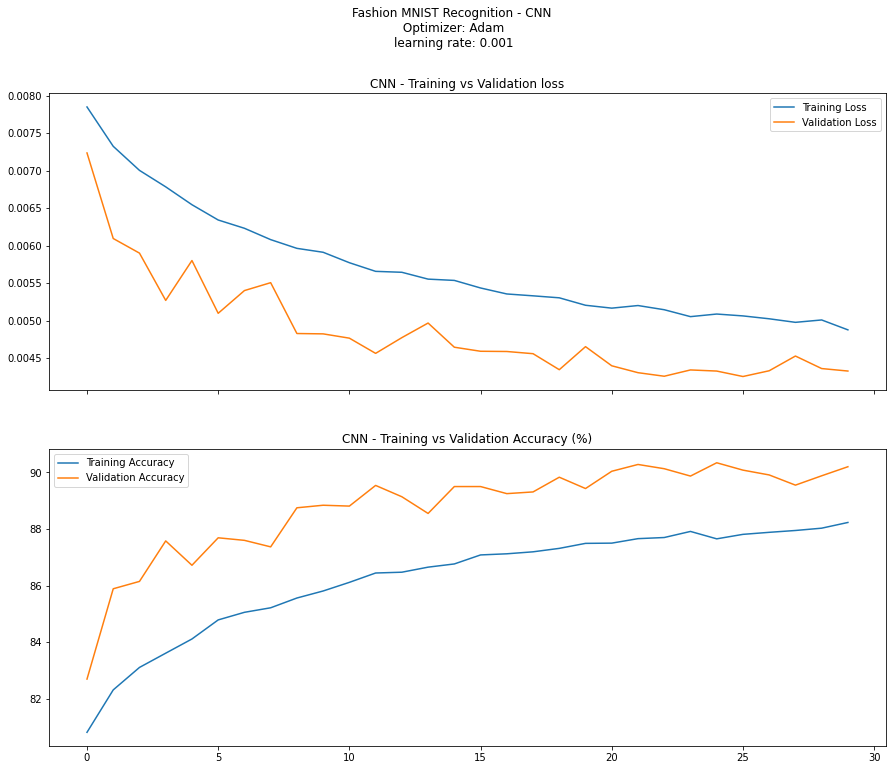

In [77]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=True, figsize=(15,12))
fig.suptitle('Fashion MNIST Recognition - CNN \n Optimizer: Adam \nlearning rate: '+ format(learning_rate))

# CNN Model Loss 
ax1.plot(training_loss_history_cnn, label="Training Loss")
ax1.plot(val_loss_history_cnn, label="Validation Loss")
ax1.title.set_text('CNN - Training vs Validation loss')
ax1.legend()

# CNN Model Accuracy 
ax2.plot(training_acc_history_cnn, label="Training Accuracy")
ax2.plot(val_acc_history_cnn, label="Validation Accuracy")
ax2.title.set_text('CNN - Training vs Validation Accuracy (%)')
ax2.legend()


for ax in fig.get_axes():
    ax.label_outer()
